In [1]:
import json
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('sachinkumar413/cxr-2-classes', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/cxr-2-classes


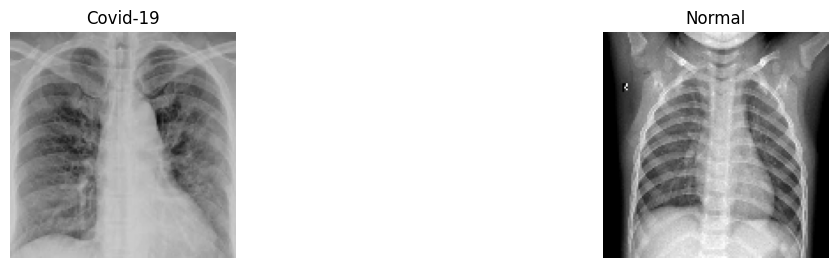

In [3]:
data_dir = 'data'
categories = os.listdir(data_dir)

plt.figure(figsize=(12, 10))
for i, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)

    # Cargar imagen original
    img = keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    plt.subplot(4, 2, i+1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 1675
Entrenamiento: 1172
Validación: 336
Test: 167


In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
)

test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
)

val_gen = test_val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    shuffle=False,
)

test_gen = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    shuffle=False,
)

Found 1172 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.


In [6]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),  # Nueva capa
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),          # Aumento de neuronas
    Dropout(0.3),                           # Aumento de dropout
    Dense(len(categories), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Esta nueva arquitectura es superior a la anterior porque incorpora una capa adicional de convolución con 64 filtros, lo que permite una extracción de características más profunda y compleja, mejorando la capacidad del modelo para reconocer patrones más abstractos en las imágenes. Además, se ha aumentado el número de neuronas en la capa densa a 32, lo que incrementa su poder representativo y facilita una mejor combinación de las características extraídas previamente. Finalmente, el aumento del valor de *dropout* a 0.3 contribuye a reducir el sobreajuste, promoviendo una mejor generalización del modelo al momento de enfrentarse a datos nuevos.

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [9]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.7449 - loss: 0.4895 - val_accuracy: 0.9792 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9637 - loss: 0.1219 - val_accuracy: 0.9792 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9535 - loss: 0.1418 - val_accuracy: 0.9792 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9626 - loss: 0.1541 - val_accuracy: 0.9732 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9656 - loss: 0.1199 - val_accuracy: 0.9851 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9784 - loss: 0.0743 - val_accuracy: 0.9762 - val_loss: 0.0888 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9789 - loss: 0.0646

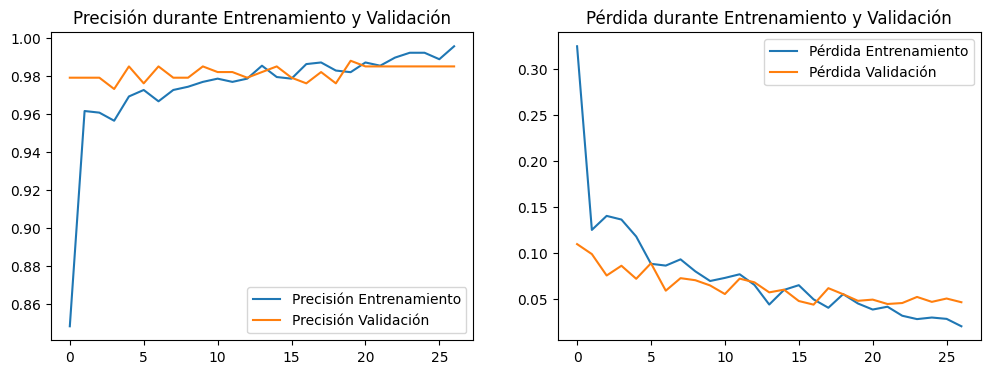

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


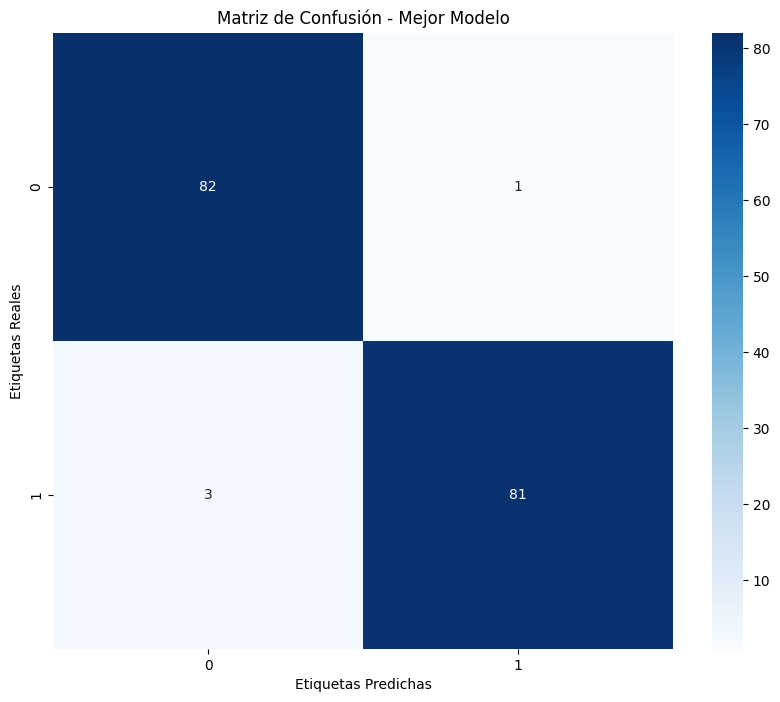

              precision    recall  f1-score   support

    Covid-19       0.96      0.99      0.98        83
      Normal       0.99      0.96      0.98        84

    accuracy                           0.98       167
   macro avg       0.98      0.98      0.98       167
weighted avg       0.98      0.98      0.98       167



In [10]:
# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_gen.reset()
predicciones = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_gen.classes

# Calcular y mostrar la matriz de confusión y el reporte de clasificación
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=categories, zero_division=0))

